**Scaffolds in small molecules - linking stories from FtsZ to ChEMBL**


**Features to demonstrate:**
- Familiarise with datamol packages and scaffold_finder library (acknowledging Practical Cheminformatics blog by P. Walters)
- Using Polars dataframe library for initial data wrangling along with datamol Python library & the later trial of scaffold_finder library (probably a small degree only, as datamol was likely written with Pandas in mind only, and also Pandas was the more commonly applied dataframe library in many cheminformatics packages & libraries)
- Integrating experimental results from paper in PhD work into cheminformatics project (validation always crucial for computational predictions)
- Advancing from pure organic chemistry and computational chemistry without code into utilising data science tools and packages by coding in Python to guide drug discovery project directions

**Key question**: Will compound 3's scaffold be similar to the scaffolds of any approved anti-infectives? 
- if similar ?implying it might be a good hit with different R-groups (?similar bacterial targets between cpd3 and other Rx anti-infectives, if so this can be backed up with experimental findings from the paper, or if different scaffolds, it might lead to a new type of anti-infective hits - consider comparing target binding site for anti-infective ?good for comparing protein-ligand interaction)

**Tasks for current post**: 
- Convert anti-infective compounds & compounds 1-3's SMILES into SELFIES (more robust for ML models) 
- Get scaffolds of the anti-infective compounds from ChEMBL + compounds 1-3 
- Align scaffolds of compounds 1-3 with other scaffolds from ChEMBL
- Look for MCS (maximum common structure) - use RDKit (?separate post)
- Identify any similarities or differences between anti-infectives from ChEMBL and compound 3

**Data cleaning for ChEMBL anti-infectives**

In [1]:
import polars as pl
import pandas as pd
import datamol as dm
import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDepictor import Compute2DCoords

In [2]:
df_ai = pl.read_csv("chembl_anti-inf.csv", separator = ";")
df_ai

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL374975""","""FUSIDIC ACID""","""ANHYDROUS FUSI…","""CEM-102|NSC-56…",4.0,"""""","""""","""1967""","""""","""""","""""","""J01XC01 | S01A…","""J01XC - Steroi…","""J01X - OTHER A…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",0,0,0,0,0,"""Unknown""","""CC(=O)O[C@H]1C…"
"""CHEMBL130""","""CHLORAMPHENICO…","""9-HYDROXY-9-PH…","""NSC-16331|NSC-…",4.0,"""Ivax Pharmaceu…","""""","""""","""""","""""","""1950""","""S01AA01 | S03A…","""S01AA - Antibi…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial;…","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,1,1,0,"""Unknown""","""O=C(N[C@H](CO)…"
"""CHEMBL186""","""CEFEPIME""","""BMY-28142|CEFE…","""BMY-28142|J01D…",4.0,"""Samson Medical…","""'cef-'""","""1987""","""cephalosporins…","""'cef-(cef-)'""","""1996""","""J01DE01""","""J01DE - Fourth…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CO/N=C(\C(=O)N…"
"""CHEMBL222645""","""FLOXACILLIN""","""ABBOFLOX|BRL 2…","""BRL 2039|BRL-2…",4.0,"""""","""'-cillin'""","""1972""","""penicillins""","""'-cillin(-cill…","""""","""J01CF05""","""J01CF - Beta-l…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,0,0,0,"""Unknown""","""Cc1onc(-c2c(F)…"
"""CHEMBL2364632""","""SARECYCLINE""","""P-005672|P0056…","""P-005672|P0056…",4.0,"""Almirall Llc""","""'-cycline'""","""2012""","""antibiotics (t…","""'-cycline(-cyc…","""2018""","""J01AA14""","""J01AA - Tetrac…","""J01A - TETRACY…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-8318706-B2""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""CON(C)Cc1ccc(O…"
"""CHEMBL62193""","""SULFADIMETHOXI…","""Madribon|NSC-6…","""NSC-683544|NSC…",4.0,"""""","""'sulfa-'""","""""","""antimicrobials…","""'sulfa-(sulfa-…","""""","""J01ED01""","""J01ED - Long-a…","""J01E - SULFONA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",0,0,0,0,0,"""Withdrawn""","""COc1cc(NS(=O)(…"
"""CHEMBL2303613""","""CEFODIZIME""","""CEFODIZIME|CEF…","""HR 221|HR 221 …",4.0,"""""","""'cef-'""","""""","""cephalosporins…","""'cef-(cef-)'""","""""","""J01DD09""","""J01DD - Third-…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""None""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",0,0,0,0,0,"""Unknown""","""CO/N=C(\C(=O)N…"
"""CHEMBL31""","""GATIFLOXACIN""","""AM-1155|BMS-20…","""AM-1155|BMS-20…",4.0,"""Apotex Inc|Bri…","""'-oxacin'""","""1997""","""antibacterials…","""'-oxacin(-oxac…","""1999""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Racemic Mixtur…",0,1,1,1,0,"""Prescription O…","""COc1c(N2CCNC(C…"
"""CHEMBL268869""","""SULFAMETHOXYPY…","""CL-13494|DEPOV…","""CL-13494|NSC-7…",4.0,"""""","""'sulfa-'""","""""","""antimicrobials…","""'sulfa-(sulfa-…","""""","""J01ED05""","""J01ED - Long-a…","""J01E - SULFONA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",0,0,0,0,0,"""Withdrawn""","""COc1ccc(NS(=O)…"


In [3]:
print(df_ai.glimpse())

Rows: 144
Columns: 29
$ Parent Molecule     <str> CHEMBL374975, CHEMBL130, CHEMBL186, CHEMBL222645, CHEMBL2364632, CHEMBL62193, CHEMBL2303613, CHEMBL31, CHEMBL268869, CHEMBL3039597
$ Name                <str> FUSIDIC ACID, CHLORAMPHENICOL, CEFEPIME, FLOXACILLIN, SARECYCLINE, SULFADIMETHOXINE, CEFODIZIME, GATIFLOXACIN, SULFAMETHOXYPYRIDAZINE, GENTAMICIN
$ Synonyms            <str> ANHYDROUS FUSIDIC ACID|CEM-102|FUCIDIN CAVIJECT|FUCITHALMIC|FUSIDATE|FUSIDIC ACID|NSC-56192|RAMYCIN|SQ 16,603|SQ-16603|TAKSTA, 9-HYDROXY-9-PHENYLXANTHENE|9-PHENYL-9H-XANTHEN-9-OL|AMPHICOL|BROCHLOR|BROLENE ANTIBIOTIC|CHLORAMPHENICOL|CHLOROFAIR|CHLOROPTIC|CHLOROPTIC S.O.P.|Chloramex|Chloramphenicol|Chlorbiotic|Chloromycetin|ECONOCHLOR|GOLDEN EYE ANTIBIOTIC|KEMICETINE|KLORAFECT|Kernispray|MYCHEL|Mychel-S|NSC-16331|NSC-3069|OPHTHOCHLOR|OPTOMYCIN|SNO PHENICOL|TUBILUX INFECTED EYES|Tevcocin|XANTHEN-9-OL, 9-PHENYL-, BMY-28142|CEFEPIME|J01DE01|Maxipime|RENAPIME|VNRX-5022, ABBOFLOX|BRL 2039|BRL-2039|CULPEN|FLOXACILLIN|

In [4]:
# Check availability types
df_ai.groupby("Availability Type").count()

Availability Type,count
str,u32
"""Withdrawn""",7
"""Prescription O…",72
"""Discontinued""",36
"""Unknown""",29


In [5]:
# Selecting only compounds that are prescription-only meds
df_ai_rx = df_ai.filter(pl.col("Availability Type") == "Prescription Only")
df_ai_rx

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL186""","""CEFEPIME""","""BMY-28142|CEFE…","""BMY-28142|J01D…",4.0,"""Samson Medical…","""'cef-'""","""1987""","""cephalosporins…","""'cef-(cef-)'""","""1996""","""J01DE01""","""J01DE - Fourth…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CO/N=C(\C(=O)N…"
"""CHEMBL2364632""","""SARECYCLINE""","""P-005672|P0056…","""P-005672|P0056…",4.0,"""Almirall Llc""","""'-cycline'""","""2012""","""antibiotics (t…","""'-cycline(-cyc…","""2018""","""J01AA14""","""J01AA - Tetrac…","""J01A - TETRACY…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-8318706-B2""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""CON(C)Cc1ccc(O…"
"""CHEMBL31""","""GATIFLOXACIN""","""AM-1155|BMS-20…","""AM-1155|BMS-20…",4.0,"""Apotex Inc|Bri…","""'-oxacin'""","""1997""","""antibacterials…","""'-oxacin(-oxac…","""1999""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Racemic Mixtur…",0,1,1,1,0,"""Prescription O…","""COc1c(N2CCNC(C…"
"""CHEMBL3039597""","""GENTAMICIN""","""GENTAMICIN|GEN…","""SCH-9724""",4.0,"""Schering Corp …","""'-micin'""","""1963""","""antibiotics (M…","""'-micin(-micin…","""1970""","""S01AA11 | S02A…","""S01AA - Antibi…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",0,0,"""Unknown""",0,0,1,1,1,"""Prescription O…","""CNC(C)[C@@H]1C…"
"""CHEMBL893""","""DICLOXACILLIN""","""BRL-1702|DICLO…","""BRL-1702|R-134…",4.0,"""Teva Pharmaceu…","""'-cillin'""","""1965""","""penicillins""","""'-cillin(-cill…","""1968""","""J01CF01""","""J01CF - Beta-l…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""Cc1onc(-c2c(Cl…"
"""CHEMBL1449""","""TICARCILLIN""","""TICARCILLIN|Ti…","""""",4.0,"""Glaxosmithklin…","""'-cillin'""","""1973""","""penicillins""","""'-cillin(-cill…","""1976""","""J01CA13""","""J01CA - Penici…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CC1(C)S[C@@H]2…"
"""CHEMBL1220""","""TINIDAZOLE""","""CP-12,574|CP-1…","""CP-12,574|CP-1…",4.0,"""Mission Pharma…","""'-nidazole'""","""1970""","""antiprotozoal …","""'-nidazole(-ni…","""2004""","""P01AB02 | J01X…","""P01AB - Nitroi…","""P01A - AGENTS …","""P01 - ANTIPROT…","""P - ANTIPARASI…","""Antiprotozoal""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",1,1,0,0,1,"""Prescription O…","""CCS(=O)(=O)CCn…"
"""CHEMBL501122""","""CEFTAROLINE FO…","""CEFTAROLINE FO…","""PPI-0903|TAK 5…",4.0,"""Apotex Inc|All…","""'cef-; fos-'""","""2006""","""cephalosporins…","""'cef-(cef-); f…","""2010""","""J01DI02""","""J01DI - Other …","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-6417175-B1""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",1,0,1,0,0,"""Prescription O…","""CCO/N=C(\C(=O)…"
"""CHEMBL137""","""METRONIDAZOLE""","""ACEA|ANABACT|B…","""BAY-5360|BAYER…",4.0,"""Inforlife Sa|L…","""'-nidazole'""","""1962""","""antiprotozoal …","""'-nidazole(-ni…","""1963""","""D06BX01 | P01A…","""D06BX - Other …","""D06B - CHEMOTH…","""D06 - ANTIBIOT…","""D - DERMATOLOG…","""Antibacterial,…","""US-6881726-B2""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",

In [6]:
# Quick overview of the statistics summary of the selected dataframe
df_ai_rx.describe()

describe,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,str,str
"""count""","""72""","""72""","""72""","""72""",72.0,"""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""",72.0,72.0,"""72""",72.0,72.0,72.0,72.0,72.0,"""72""","""72"""
"""null_count""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.583333,0.0,null,0.041667,0.611111,0.694444,0.25,0.333333,null,null
"""std""",null,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.496466,0.0,null,0.201229,0.490919,0.463875,0.436051,0.474713,null,null
"""min""","""CHEMBL1082""","""AMIKACIN""","""47663|Aktob|BE…","""""",4.0,"""Alkem Laborato…","""""","""""","""""","""""","""1941""","""A01AB23 | D10A…","""A01AB - Antiin…","""A01A - STOMATO…","""A01 - STOMATOL…","""A - ALIMENTARY…","""""","""None""","""1:Synthetic Sm…",0.0,0.0,"""Achiral Molecu…",0.0,0.0,0.0,0.0,0.0,"""Prescription O…",""""""
"""max""","""CHEMBL996""","""VANCOMYCIN""","""VANCOMYCIN|Van…","""WAY-GAR-936""",4.0,"""Xiromed Pharma…","""'sulfa-'""","""2017""","""vancomycin-rel…","""'sulfa-(sulfa-…","""2019""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Inhibitor (bet…","""US-9238657-B2""","""1:Synthetic Sm…",1.0,0.0,"""Unknown""",1.0,1.0,1.0,1.0,1.0,"""Prescription O…","""O=C1CN(/N=C/c2…"
"""median""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,0.0,1.0,1.0,0.0,0.0,null,null
"""25%""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,null,null
"""75%""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,0.0,1.0,1.0,1.0,1.0,null,null


In [7]:
# Due to the error message when converting SMILES into SELFIES using datamol, 
# Attempted to spot the missing/empty SMILES
df_ai_rx.filter(pl.col("Smiles") == "")

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL3989751""","""NEOMYCIN""","""FRADIOMYCIN|KA…","""""",4.0,"""Bayer Pharmace…","""'-mycin'""","""1966""","""antibiotics (S…","""'-mycin(-mycin…","""1957""","""R02AB01 | S01A…","""R02AB - Antibi…","""R02A - THROAT …","""R02 - THROAT P…","""R - RESPIRATOR…","""""","""None""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",0,1,0,1,1,"""Prescription O…",""""""


Below example from StackOverflow 
- https://stackoverflow.com/questions/72292048/idiomatic-replacement-of-empty-string-with-pl-null-null-in-polars

In [8]:
# only_these = ['str1', 'str2']
# df.with_columns([
#     pl.when(pl.col(only_these).str.lengths() == 0)
#     .then(None)
#     .otherwise(pl.col(only_these))
#     .keep_name()
# ])

In [9]:
# Canonical SMILES for neomycin - C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)N)OC3C(C(C(O3)CO)OC4C(C(C(C(O4)CN)O)O)N)O)O)N
# Extracted from PubChem (https://pubchem.ncbi.nlm.nih.gov/compound/Neomycin)

df_ai_rx = df_ai_rx.with_columns([
    pl.when(pl.col("Smiles").str.lengths() == 0)
    .then("C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)N)OC3C(C(C(O3)CO)OC4C(C(C(C(O4)CN)O)O)N)O)O)N")
    .otherwise(pl.col("Smiles"))
    .keep_name()
])

df_ai_rx

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL186""","""CEFEPIME""","""BMY-28142|CEFE…","""BMY-28142|J01D…",4.0,"""Samson Medical…","""'cef-'""","""1987""","""cephalosporins…","""'cef-(cef-)'""","""1996""","""J01DE01""","""J01DE - Fourth…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CO/N=C(\C(=O)N…"
"""CHEMBL2364632""","""SARECYCLINE""","""P-005672|P0056…","""P-005672|P0056…",4.0,"""Almirall Llc""","""'-cycline'""","""2012""","""antibiotics (t…","""'-cycline(-cyc…","""2018""","""J01AA14""","""J01AA - Tetrac…","""J01A - TETRACY…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-8318706-B2""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""CON(C)Cc1ccc(O…"
"""CHEMBL31""","""GATIFLOXACIN""","""AM-1155|BMS-20…","""AM-1155|BMS-20…",4.0,"""Apotex Inc|Bri…","""'-oxacin'""","""1997""","""antibacterials…","""'-oxacin(-oxac…","""1999""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Racemic Mixtur…",0,1,1,1,0,"""Prescription O…","""COc1c(N2CCNC(C…"
"""CHEMBL3039597""","""GENTAMICIN""","""GENTAMICIN|GEN…","""SCH-9724""",4.0,"""Schering Corp …","""'-micin'""","""1963""","""antibiotics (M…","""'-micin(-micin…","""1970""","""S01AA11 | S02A…","""S01AA - Antibi…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",0,0,"""Unknown""",0,0,1,1,1,"""Prescription O…","""CNC(C)[C@@H]1C…"
"""CHEMBL893""","""DICLOXACILLIN""","""BRL-1702|DICLO…","""BRL-1702|R-134…",4.0,"""Teva Pharmaceu…","""'-cillin'""","""1965""","""penicillins""","""'-cillin(-cill…","""1968""","""J01CF01""","""J01CF - Beta-l…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""Cc1onc(-c2c(Cl…"
"""CHEMBL1449""","""TICARCILLIN""","""TICARCILLIN|Ti…","""""",4.0,"""Glaxosmithklin…","""'-cillin'""","""1973""","""penicillins""","""'-cillin(-cill…","""1976""","""J01CA13""","""J01CA - Penici…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CC1(C)S[C@@H]2…"
"""CHEMBL1220""","""TINIDAZOLE""","""CP-12,574|CP-1…","""CP-12,574|CP-1…",4.0,"""Mission Pharma…","""'-nidazole'""","""1970""","""antiprotozoal …","""'-nidazole(-ni…","""2004""","""P01AB02 | J01X…","""P01AB - Nitroi…","""P01A - AGENTS …","""P01 - ANTIPROT…","""P - ANTIPARASI…","""Antiprotozoal""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",1,1,0,0,1,"""Prescription O…","""CCS(=O)(=O)CCn…"
"""CHEMBL501122""","""CEFTAROLINE FO…","""CEFTAROLINE FO…","""PPI-0903|TAK 5…",4.0,"""Apotex Inc|All…","""'cef-; fos-'""","""2006""","""cephalosporins…","""'cef-(cef-); f…","""2010""","""J01DI02""","""J01DI - Other …","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-6417175-B1""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",1,0,1,0,0,"""Prescription O…","""CCO/N=C(\C(=O)…"
"""CHEMBL137""","""METRONIDAZOLE""","""ACEA|ANABACT|B…","""BAY-5360|BAYER…",4.0,"""Inforlife Sa|L…","""'-nidazole'""","""1962""","""antiprotozoal …","""'-nidazole(-ni…","""1963""","""D06BX01 | P01A…","""D06BX - Other …","""D06B - CHEMOTH…","""D06 - ANTIBIOT…","""D - DERMATOLOG…","""Antibacterial,…","""US-6881726-B2""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",

In [10]:
# Keeping only selected columns with information needed for later use
df_ai_rx = df_ai_rx.select(["Smiles", "Name", "USAN Definition", "Level 4 ATC Codes"])
df_ai_rx.head()

Smiles,Name,USAN Definition,Level 4 ATC Codes
str,str,str,str
"""CO/N=C(\C(=O)N…","""CEFEPIME""","""cephalosporins…","""J01DE - Fourth…"
"""CON(C)Cc1ccc(O…","""SARECYCLINE""","""antibiotics (t…","""J01AA - Tetrac…"
"""COc1c(N2CCNC(C…","""GATIFLOXACIN""","""antibacterials…","""S01AE - Fluoro…"
"""CNC(C)[C@@H]1C…","""GENTAMICIN""","""antibiotics (M…","""S01AA - Antibi…"
"""Cc1onc(-c2c(Cl…","""DICLOXACILLIN""","""penicillins""","""J01CF - Beta-l…"


In [11]:
# Change column name of "Smiles" - to ensure the _preprocess function will work
# as smiles_column = "smiles" with lowercase "s" - will be using this function
# to cater for the 3 FtsZ compounds as well
df_ai_rx = df_ai_rx.rename({"Smiles": "smiles", "Name": "names"})
df_ai_rx.head()

smiles,names,USAN Definition,Level 4 ATC Codes
str,str,str,str
"""CO/N=C(\C(=O)N…","""CEFEPIME""","""cephalosporins…","""J01DE - Fourth…"
"""CON(C)Cc1ccc(O…","""SARECYCLINE""","""antibiotics (t…","""J01AA - Tetrac…"
"""COc1c(N2CCNC(C…","""GATIFLOXACIN""","""antibacterials…","""S01AE - Fluoro…"
"""CNC(C)[C@@H]1C…","""GENTAMICIN""","""antibiotics (M…","""S01AA - Antibi…"
"""Cc1onc(-c2c(Cl…","""DICLOXACILLIN""","""penicillins""","""J01CF - Beta-l…"


In [12]:
# Convert all compounds to lowercases
df_ai_rx = df_ai_rx.with_columns(pl.col("names").str.to_lowercase())
df_ai_rx.head()

smiles,names,USAN Definition,Level 4 ATC Codes
str,str,str,str
"""CO/N=C(\C(=O)N…","""cefepime""","""cephalosporins…","""J01DE - Fourth…"
"""CON(C)Cc1ccc(O…","""sarecycline""","""antibiotics (t…","""J01AA - Tetrac…"
"""COc1c(N2CCNC(C…","""gatifloxacin""","""antibacterials…","""S01AE - Fluoro…"
"""CNC(C)[C@@H]1C…","""gentamicin""","""antibiotics (M…","""S01AA - Antibi…"
"""Cc1onc(-c2c(Cl…","""dicloxacillin""","""penicillins""","""J01CF - Beta-l…"


In [13]:
list(df_ai_rx["USAN Definition"])

['cephalosporins',
 'antibiotics (tetracycline derivatives)',
 'antibacterials (quinolone derivatives)',
 'antibiotics (Micromonospora strains)',
 'penicillins',
 'penicillins',
 'antiprotozoal substances (metronidazole type)',
 'cephalosporins; phosphoro-derivatives',
 'antiprotozoal substances (metronidazole type)',
 'antibiotics (tetracycline derivatives)',
 'antibiotics (Streptomyces strain)',
 'antibiotics (Streptomyces strain)',
 'antibiotics (tetracycline derivatives)',
 'cephalosporins',
 'cephalosporins',
 'antibiotics (Streptomyces strain)',
 '',
 'antibiotics obtained from Streptomyces kanamyceticus (related to kanamycin)',
 'cephalosporins',
 'penicillins',
 'antibiotics (tetracycline derivatives)',
 'antibiotics (Streptomyces strain)',
 'antibiotics (tetracycline derivatives)',
 'antibiotics (Micromonospora strains)',
 'penicillins',
 'penicillins',
 'antibiotics (Streptomyces strain)',
 'antibiotics (tetracycline derivatives)',
 'antibiotics (Streptomyces strain)',
 'anti

In [14]:
# Convert polars dataframe into a pandas dataframe (as datamol likely only compatible with Pandas for now)
df_ai_pd = df_ai_rx.to_pandas()
df_ai_pd

,smiles,names,USAN Definition,Level 4 ATC Codes
0,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,cefepime,cephalosporins,J01DE - Fourth-generation cephalosporins
1,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,sarecycline,antibiotics (tetracycline derivatives),J01AA - Tetracyclines
2,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,gatifloxacin,antibacterials (quinolone derivatives),S01AE - Fluoroquinolones | J01MA - Fluoroquino...
3,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,gentamicin,antibiotics (Micromonospora strains),S01AA - Antibiotics | S02AA - Antiinfectives |...
4,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,dicloxacillin,penicillins,J01CF - Beta-lactamase resistant penicillins
...,...,...,...,...
67,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,benzylpenicillin,penicillins,J01CE - Beta-lactamase sensitive penicillins |...
68,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,ciprofloxacin,antibacterials (quinolone derivatives),J01MA - Fluoroquinolones | S03AA - Antiinfecti...
69,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,norfloxacin,antibacterials (quinolone derivatives),J01MA - Fluoroquinolones | S01AE - Fluoroquino...
70,Nc1ccc(S(N)(=O)=O)cc1,sulfanilamide,antimicrobials (sulfonamides derivatives),D06BA - Sulfonamides | J01EB - Short-acting su...


In [15]:
# Check the dataframe has been converted from Polars to Pandas
type(df_ai_pd)

pandas.core.frame.DataFrame

**Pre-processing and standardising molecules**

In [16]:

# Pre-process molecules using _preprocess function - adapted with courtesy from datamol.io

smiles_column = "smiles"

dm.disable_rdkit_log()

def _preprocess(row):
    mol = dm.to_mol(row[smiles_column], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(
        mol,
        disconnect_metals=False,
        normalize=True,
        reionize=True,
        uncharge=False,
        stereo=True,
    )

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

In [17]:
# Issue found with one compound that acutally had no SMILES recorded in the dataframe!
# **Fixed by adding the missing SMILES for neomycin**

# Two methods to convert SMILES into SELFIES

# Method one - using lambda function:
# df_ai_pd["selfies"] = df_ai_pd["Smiles"].apply(lambda x: dm.to_selfies(x))
# df_ai_pd

# Method two - using _preprocess function:
data_mol_clean = df_ai_pd.apply(_preprocess, axis = 1)
data_mol_clean

,smiles,names,USAN Definition,Level 4 ATC Codes,standard_smiles,selfies,inchi,inchikey
0,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,cefepime,cephalosporins,J01DE - Fourth-generation cephalosporins,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,[C][O][/N][=C][Branch2][Ring2][#Branch2][\C][=...,InChI=1S/C19H24N6O5S2/c1-25(5-3-4-6-25)7-10-8-...,HVFLCNVBZFFHBT-ZKDACBOMSA-N
1,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,sarecycline,antibiotics (tetracycline derivatives),J01AA - Tetracyclines,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,[C][O][N][Branch1][C][C][C][C][=C][C][=C][Bran...,InChI=1S/C24H29N3O8/c1-26(2)18-13-8-11-7-12-10...,PQJQFLNBMSCUSH-SBAJWEJLSA-N
2,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,gatifloxacin,antibacterials (quinolone derivatives),S01AE - Fluoroquinolones | J01MA - Fluoroquino...,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,[C][O][C][=C][Branch1][N][N][C][C][N][C][Branc...,InChI=1S/C19H22FN3O4/c1-10-8-22(6-5-21-10)16-1...,XUBOMFCQGDBHNK-UHFFFAOYSA-N
3,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,gentamicin,antibiotics (Micromonospora strains),S01AA - Antibiotics | S02AA - Antiinfectives |...,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,[C][N][C][Branch1][C][C][C@@H1][C][C][C@@H1][B...,InChI=1S/C21H43N5O7.C20H41N5O7.C19H39N5O7/c1-9...,NPEFREDMMVQEPL-RWPARATISA-N
4,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,dicloxacillin,penicillins,J01CF - Beta-lactamase resistant penicillins,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,[C][C][O][N][=C][Branch1][=N][C][=C][Branch1][...,InChI=1S/C19H17Cl2N3O5S/c1-7-10(12(23-29-7)11-...,YFAGHNZHGGCZAX-JKIFEVAISA-N
...,...,...,...,...,...,...,...,...
67,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,benzylpenicillin,penicillins,J01CE - Beta-lactamase sensitive penicillins |...,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,[C][C][Branch1][C][C][S][C@@H1][C@H1][Branch1]...,InChI=1S/C16H18N2O4S/c1-16(2)12(15(21)22)18-13...,JGSARLDLIJGVTE-MBNYWOFBSA-N
68,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,ciprofloxacin,antibacterials (quinolone derivatives),J01MA - Fluoroquinolones | S03AA - Antiinfecti...,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,[O][=C][Branch1][C][O][C][=C][N][Branch1][=Bra...,InChI=1S/C17H18FN3O3/c18-13-7-11-14(8-15(13)20...,MYSWGUAQZAJSOK-UHFFFAOYSA-N
69,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,norfloxacin,antibacterials (quinolone derivatives),J01MA - Fluoroquinolones | S01AE - Fluoroquino...,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,[C][C][N][C][=C][Branch1][=Branch1][C][=Branch...,InChI=1S/C16H18FN3O3/c1-2-19-9-11(16(22)23)15(...,OGJPXUAPXNRGGI-UHFFFAOYSA-N
70,Nc1ccc(S(N)(=O)=O)cc1,sulfanilamide,antimicrobials (sulfonamides derivatives),D06BA - Sulfonamides | J01EB - Short-acting su...,Nc1ccc(S(N)(=O)=O)cc1,[N][C][=C][C][=C][Branch1][=Branch2][S][Branch...,"InChI=1S/C6H8N2O2S/c7-5-1-3-6(4-2-5)11(8,9)10/...",FDDDEECHVMSUSB-UHFFFAOYSA-N


In [18]:
# Tested: Selfies conversion Works for one SMILES
# selfies = dm.to_selfies("O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl")
# selfies

**Visualise the compounds in 2D**

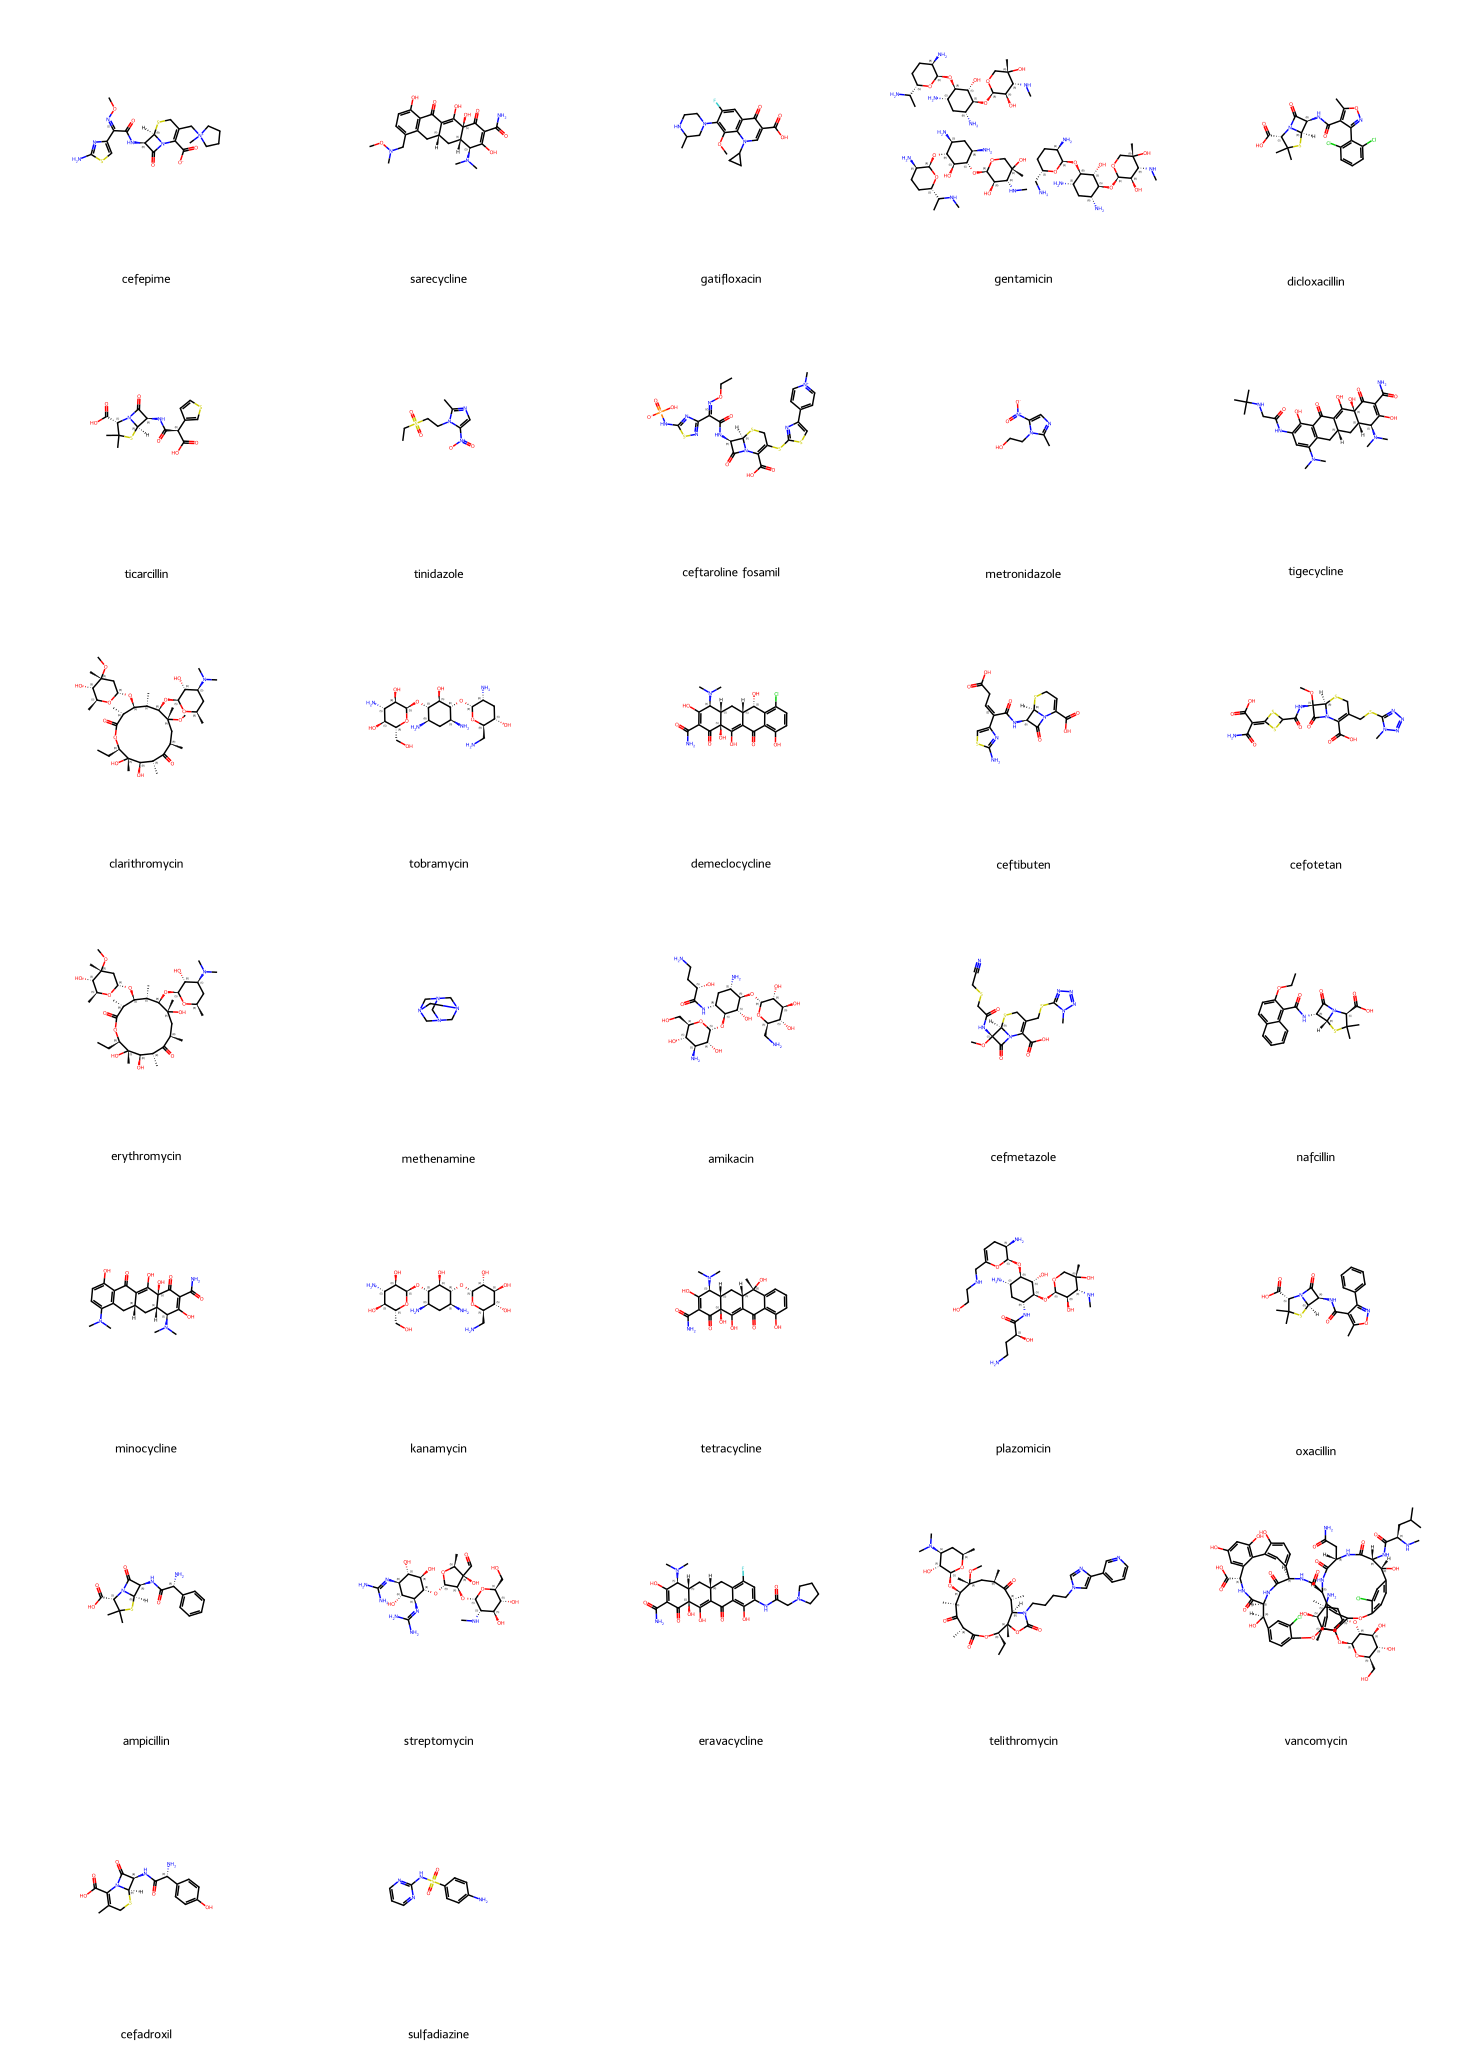

In [19]:
# Grab all SMILES from cleaned ChEMBL anti-infective dataset
df_ai_sm = data_mol_clean["standard_smiles"]
# Load a list of these molecules in SMILES
# dm.to_mol with sanitize = True set as default
mol_ls = [dm.to_mol(smile) for smile in df_ai_sm]
# Alternative way to convert dataframe into a list of mols (same as mol_ls)
# mols = dm.from_df(df_name, smiles_column = "Smiles")
# Add compound name for each 2D image of compounds
legends_c = list(data_mol_clean["names"])
# Convert the list of molecules into 2D images
dm.to_image(mol_ls, n_cols = 5, mol_size = (400, 400), legends = legends_c)

**Extract scaffolds**

In [20]:
# Extract Murcko scaffolds from mol_ls (ChEMBL anti-infectives)
m_scaffolds = [dm.to_scaffold_murcko(mol) for mol in mol_ls]
#dm.to_image(m_scaffolds, mol_size = (400, 400), legends = legends_c)

In [21]:
type(m_scaffolds)

list

**Data cleaning for FtsZ compounds**

The section below focuses on 3 compounds from this paper - Lin, H.-Y.J.; Battaje, R.R.;
Tan, J.; Doddareddy, M.; Dhaked, H.P.S.; Srivastava, S.; Hawkins, B.A.; Al-Shdifat, L.M.H.; Hibbs, D.E.; Panda, D.; et al. Discovery of 2',6-Bis(4-hydroxybenzyl)-2-acetylcyclohexanone, a Novel FtsZ
Inhibitor. Molecules 2022, 27, 6993. https://doi.org/10.3390/molecules27206993

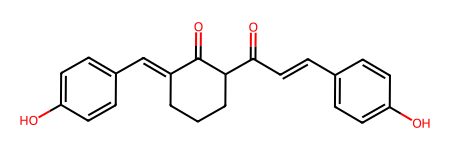

In [22]:
# Convert compound 1 to mol from InChI
cpd1 = dm.from_inchi("InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-21(25)20-3-1-2-17(22(20)26)14-16-6-11-19(24)12-7-16/h4-14,20,23-24H,1-3H2/b13-8+,17-14+")
cpd1

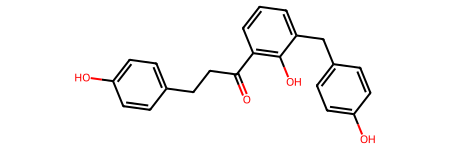

In [23]:
# Convert compound 2 SMILES to mol
cpd2 = dm.to_mol("OC1=C(C=CC=C1CC1=CC=C(C=C1)O)C(CCC1=CC=C(C=C1)O)=O")
cpd2

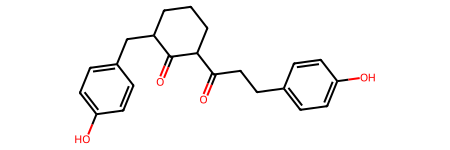

In [24]:
# Convert compound 3 SMILES to mol
cpd3 = dm.to_mol("OC1=CC=C(CC2C(C(CCC2)C(CCC2=CC=C(C=C2)O)=O)=O)C=C1")
cpd3

In [25]:
# Save these 3 compounds into a list
mol_lst = [cpd1, cpd2, cpd3]
mol_lst

In [26]:
# Convert a list of mols to a dataframe
df = dm.to_df(mol_lst)
df

,smiles
0,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O
1,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O
2,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O


In [27]:
names = ["Compound_1", "Compound_2", "Compound_3"]
df["names"] = names
df

,smiles,names
0,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,Compound_1
1,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,Compound_2
2,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O,Compound_3


In [28]:
# Pre-process FtsZ compounds
data_cleaned = df.apply(_preprocess, axis=1)
data_cleaned

,smiles,names,standard_smiles,selfies,inchi,inchikey
0,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,Compound_1,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,[O][=C][Branch1][=C][/C][=C][/C][=C][C][=C][Br...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,QNBFRAOWJNMPAF-ZIQQYUHESA-N
1,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,Compound_2,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,[O][=C][Branch1][=C][C][C][C][=C][C][=C][Branc...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,CWVXMBYGWRWONE-UHFFFAOYSA-N
2,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O,Compound_3,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O,[O][=C][Branch1][=C][C][C][C][=C][C][=C][Branc...,InChI=1S/C22H24O4/c23-18-9-4-15(5-10-18)8-13-2...,KWPXNGBFYRHREW-UHFFFAOYSA-N


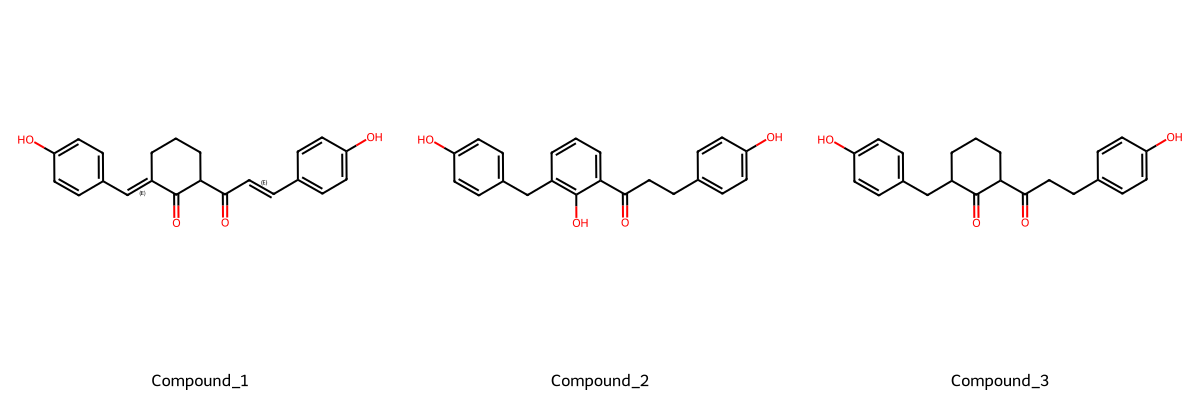

In [29]:
# Place FtsZ compounds in 2D images
# Grab all SMILES from cleaned FtsZ compound dataset
df_ai_ftsz = data_cleaned["standard_smiles"]
# Load a list of these molecules in SMILES
mol_ftsz_list = [dm.to_mol(smile) for smile in df_ai_ftsz]
# Add compound name for each 2D image of compounds
legends = list(data_cleaned["names"])
# Convert the list of molecules into 2D images
dm.to_image(mol_ftsz_list, n_cols = 5, mol_size = (400, 400), legends = legends)

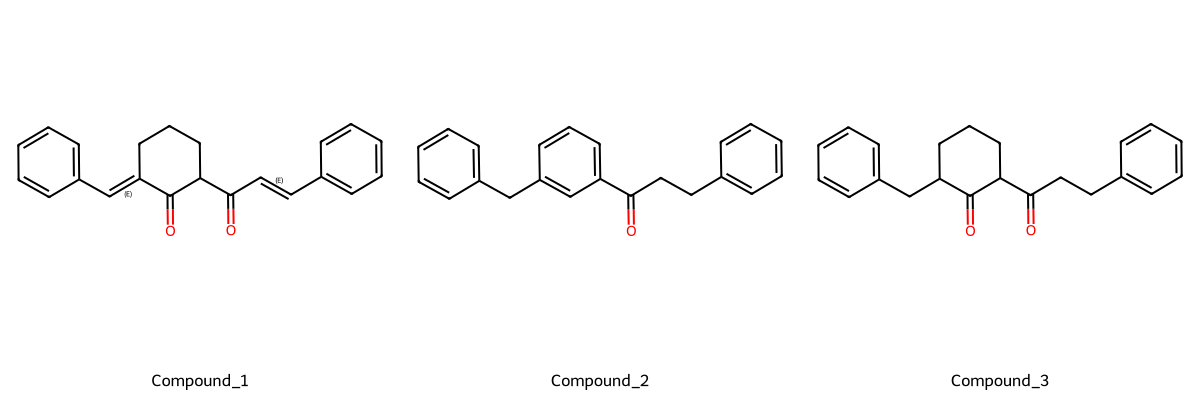

In [30]:
# Get Murcko scaffolds of FtsZ compounds
m_ftsz_scaffolds = [dm.to_scaffold_murcko(mol) for mol in mol_ftsz_list]
dm.to_image(m_ftsz_scaffolds, mol_size = (400, 400), legends = legends)

**Aligning scaffolds**

- Align scaffolds between ChEMBL Rx anti-infectives and FtsZ compounds

- (optional) Separate ChEMBL Rx anti-infective compounds into clusters - aiming to look for common scaffold

- If none, choose a template molecule (? search for most similar compound against FtsZ compounds first) & compare FtsZ compounds with it

In [31]:
# Align ChEMBL anti-infective compounds first
# **Check out auto_align_many() method**
# "anon-scaffold" is the default partition method
# "cluster" partition method generated weird-looking compounds 
# - ?to set cluster cut-off as it was stated it was sensitive to cutoff


# aligned_list = dm.align.auto_align_many(mol_ls, partition_method = "anon-scaffold")
# dm.to_image(aligned_list, mol_size = (400, 400), legends = legends_c)

In [32]:
# Combine dataframes of cleaned ChEMBL anti-infectives & cleaned FtsZ compounds
combined_lists = [data_mol_clean, data_cleaned]
full_data = pd.concat(combined_lists, ignore_index = True)
full_data

,smiles,names,USAN Definition,Level 4 ATC Codes,standard_smiles,selfies,inchi,inchikey
0,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,cefepime,cephalosporins,J01DE - Fourth-generation cephalosporins,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,[C][O][/N][=C][Branch2][Ring2][#Branch2][\C][=...,InChI=1S/C19H24N6O5S2/c1-25(5-3-4-6-25)7-10-8-...,HVFLCNVBZFFHBT-ZKDACBOMSA-N
1,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,sarecycline,antibiotics (tetracycline derivatives),J01AA - Tetracyclines,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,[C][O][N][Branch1][C][C][C][C][=C][C][=C][Bran...,InChI=1S/C24H29N3O8/c1-26(2)18-13-8-11-7-12-10...,PQJQFLNBMSCUSH-SBAJWEJLSA-N
2,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,gatifloxacin,antibacterials (quinolone derivatives),S01AE - Fluoroquinolones | J01MA - Fluoroquino...,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,[C][O][C][=C][Branch1][N][N][C][C][N][C][Branc...,InChI=1S/C19H22FN3O4/c1-10-8-22(6-5-21-10)16-1...,XUBOMFCQGDBHNK-UHFFFAOYSA-N
3,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,gentamicin,antibiotics (Micromonospora strains),S01AA - Antibiotics | S02AA - Antiinfectives |...,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,[C][N][C][Branch1][C][C][C@@H1][C][C][C@@H1][B...,InChI=1S/C21H43N5O7.C20H41N5O7.C19H39N5O7/c1-9...,NPEFREDMMVQEPL-RWPARATISA-N
4,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,dicloxacillin,penicillins,J01CF - Beta-lactamase resistant penicillins,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,[C][C][O][N][=C][Branch1][=N][C][=C][Branch1][...,InChI=1S/C19H17Cl2N3O5S/c1-7-10(12(23-29-7)11-...,YFAGHNZHGGCZAX-JKIFEVAISA-N
...,...,...,...,...,...,...,...,...
70,Nc1ccc(S(N)(=O)=O)cc1,sulfanilamide,antimicrobials (sulfonamides derivatives),D06BA - Sulfonamides | J01EB - Short-acting su...,Nc1ccc(S(N)(=O)=O)cc1,[N][C][=C][C][=C][Branch1][=Branch2][S][Branch...,"InChI=1S/C6H8N2O2S/c7-5-1-3-6(4-2-5)11(8,9)10/...",FDDDEECHVMSUSB-UHFFFAOYSA-N
71,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,ofloxacin,antibacterials (quinolone derivatives),J01MA - Fluoroquinolones | S02AA - Antiinfecti...,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,[C][C][C][O][C][=C][Branch1][N][N][C][C][N][Br...,InChI=1S/C18H20FN3O4/c1-10-9-26-17-14-11(16(23...,GSDSWSVVBLHKDQ-UHFFFAOYSA-N
72,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,Compound_1,NaN,NaN,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,[O][=C][Branch1][=C][/C][=C][/C][=C][C][=C][Br...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,QNBFRAOWJNMPAF-ZIQQYUHESA-N
73,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,Compound_2,NaN,NaN,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,[O][=C][Branch1][=C][C][C][C][=C][C][=C][Branc...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,CWVXMBYGWRWONE-UHFFFAOYSA-N


In [33]:
df_full = full_data["standard_smiles"]
df_full

0     CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
1     CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...
2     COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...
3     CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...
4     Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...
                            ...                        
70                                Nc1ccc(S(N)(=O)=O)cc1
71     CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
72     O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O
73            O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O
74           O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O
Name: standard_smiles, Length: 75, dtype: object

In [34]:
mol_full = [dm.to_mol(smile) for smile in df_full]
mol_full

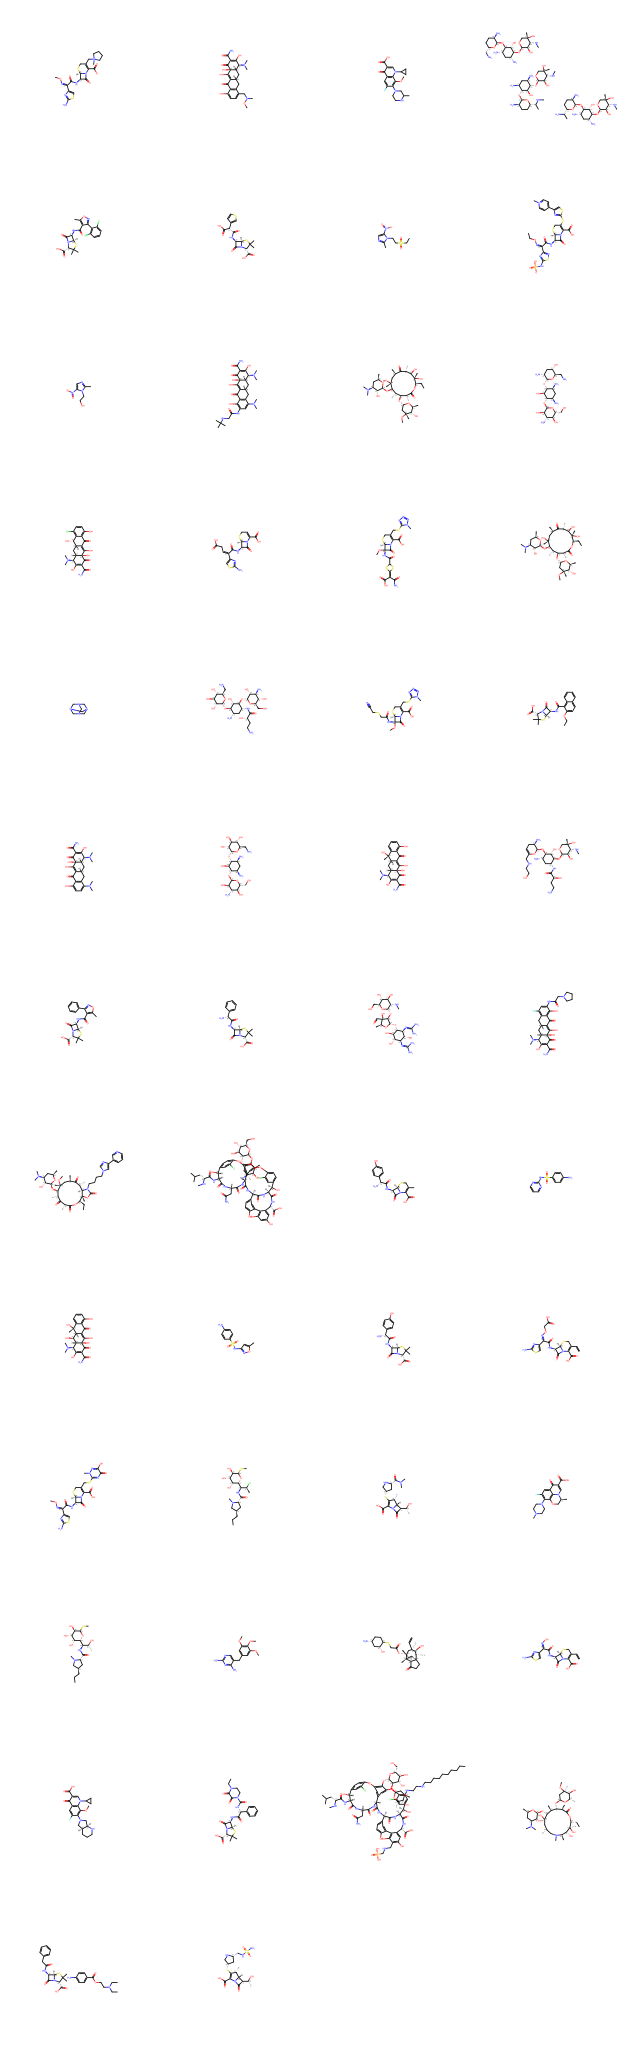

In [35]:
aligned_list = dm.align.auto_align_many(mol_full, partition_method = "anon-scaffold")
dm.to_image(aligned_list, mol_size = (400, 400), max_mols = 50)

# compound structures did re-align in this code

In [36]:
type(aligned_list)

list

In [37]:
# Using datamol's auto_align_many() to align the scaffolds in mols2grid
mols2grid.display(aligned_list)

# Issue: Unfortunately, compounds did not re-align when combining datamol & mols2grid together

MolGridWidget()

In [38]:

# Issue: Max number of compounds to display as 2D images = 50 (we have here a total of 75 compounds)

# Trying mols2grid instead
# Full dataset of 75 compounds 
mols2grid.display(full_data, smiles_col = "standard_smiles", subset = ["img", "mols2grid-id", "names"])

# Able to display 2D images of all 75 compounds

MolGridWidget()

In [39]:
# Showing scaffolds of ChEMBL Rx anti-infectives

# **Some scaffolds are repeated e.g. 6 & 8 
# - consider adding count column into the scaffold dataframe**

mols2grid.display(m_scaffolds)

MolGridWidget()

In [40]:
# Showing scaffolds of FtsZ compounds
mols2grid.display(m_ftsz_scaffolds)

MolGridWidget()

In [41]:
# Using scaffold_finder library from Practical Cheminformatics blog
# Borrow the scaffold_finder.py script (small Python library for scaffold work) from P. Walters
from scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment

In [42]:
full_data

,smiles,names,USAN Definition,Level 4 ATC Codes,standard_smiles,selfies,inchi,inchikey
0,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,cefepime,cephalosporins,J01DE - Fourth-generation cephalosporins,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,[C][O][/N][=C][Branch2][Ring2][#Branch2][\C][=...,InChI=1S/C19H24N6O5S2/c1-25(5-3-4-6-25)7-10-8-...,HVFLCNVBZFFHBT-ZKDACBOMSA-N
1,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,sarecycline,antibiotics (tetracycline derivatives),J01AA - Tetracyclines,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,[C][O][N][Branch1][C][C][C][C][=C][C][=C][Bran...,InChI=1S/C24H29N3O8/c1-26(2)18-13-8-11-7-12-10...,PQJQFLNBMSCUSH-SBAJWEJLSA-N
2,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,gatifloxacin,antibacterials (quinolone derivatives),S01AE - Fluoroquinolones | J01MA - Fluoroquino...,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,[C][O][C][=C][Branch1][N][N][C][C][N][C][Branc...,InChI=1S/C19H22FN3O4/c1-10-8-22(6-5-21-10)16-1...,XUBOMFCQGDBHNK-UHFFFAOYSA-N
3,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,gentamicin,antibiotics (Micromonospora strains),S01AA - Antibiotics | S02AA - Antiinfectives |...,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,[C][N][C][Branch1][C][C][C@@H1][C][C][C@@H1][B...,InChI=1S/C21H43N5O7.C20H41N5O7.C19H39N5O7/c1-9...,NPEFREDMMVQEPL-RWPARATISA-N
4,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,dicloxacillin,penicillins,J01CF - Beta-lactamase resistant penicillins,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,[C][C][O][N][=C][Branch1][=N][C][=C][Branch1][...,InChI=1S/C19H17Cl2N3O5S/c1-7-10(12(23-29-7)11-...,YFAGHNZHGGCZAX-JKIFEVAISA-N
...,...,...,...,...,...,...,...,...
70,Nc1ccc(S(N)(=O)=O)cc1,sulfanilamide,antimicrobials (sulfonamides derivatives),D06BA - Sulfonamides | J01EB - Short-acting su...,Nc1ccc(S(N)(=O)=O)cc1,[N][C][=C][C][=C][Branch1][=Branch2][S][Branch...,"InChI=1S/C6H8N2O2S/c7-5-1-3-6(4-2-5)11(8,9)10/...",FDDDEECHVMSUSB-UHFFFAOYSA-N
71,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,ofloxacin,antibacterials (quinolone derivatives),J01MA - Fluoroquinolones | S02AA - Antiinfecti...,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,[C][C][C][O][C][=C][Branch1][N][N][C][C][N][Br...,InChI=1S/C18H20FN3O4/c1-10-9-26-17-14-11(16(23...,GSDSWSVVBLHKDQ-UHFFFAOYSA-N
72,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,Compound_1,NaN,NaN,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,[O][=C][Branch1][=C][/C][=C][/C][=C][C][=C][Br...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,QNBFRAOWJNMPAF-ZIQQYUHESA-N
73,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,Compound_2,NaN,NaN,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,[O][=C][Branch1][=C][C][C][C][=C][C][=C][Branc...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,CWVXMBYGWRWONE-UHFFFAOYSA-N


In [43]:
# Try scaffold_finder functions on ChEMBL Rx anti-infectives

# 1) add mol column to full_data dataframe (needed to use functions from scaffold_finder library)
full_data["mol"] = full_data.standard_smiles.apply(Chem.MolFromSmiles)

In [47]:
# Change column names of "standard_smiles" to "SMILES" & "names" to "Name"
# To match with scaffold_finder library functions with set column names
# Note: New column name "SMILES" = standardised SMILES (old column name as "standard_smiles")
full_data = full_data.rename(columns = {"standard_smiles": "SMILES", "names": "Name"})
full_data.head()

,smiles,Name,USAN Definition,Level 4 ATC Codes,SMILES,selfies,inchi,inchikey,mol
0,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,cefepime,cephalosporins,J01DE - Fourth-generation cephalosporins,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,[C][O][/N][=C][Branch2][Ring2][#Branch2][\C][=...,InChI=1S/C19H24N6O5S2/c1-25(5-3-4-6-25)7-10-8-...,HVFLCNVBZFFHBT-ZKDACBOMSA-N,<rdkit.Chem.rdchem.Mol object at 0x12eb99ee0>
1,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,sarecycline,antibiotics (tetracycline derivatives),J01AA - Tetracyclines,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,[C][O][N][Branch1][C][C][C][C][=C][C][=C][Bran...,InChI=1S/C24H29N3O8/c1-26(2)18-13-8-11-7-12-10...,PQJQFLNBMSCUSH-SBAJWEJLSA-N,<rdkit.Chem.rdchem.Mol object at 0x12eb9bd10>
2,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,gatifloxacin,antibacterials (quinolone derivatives),S01AE - Fluoroquinolones | J01MA - Fluoroquino...,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,[C][O][C][=C][Branch1][N][N][C][C][N][C][Branc...,InChI=1S/C19H22FN3O4/c1-10-8-22(6-5-21-10)16-1...,XUBOMFCQGDBHNK-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x12eb9bb50>
3,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,gentamicin,antibiotics (Micromonospora strains),S01AA - Antibiotics | S02AA - Antiinfectives |...,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,[C][N][C][Branch1][C][C][C@@H1][C][C][C@@H1][B...,InChI=1S/C21H43N5O7.C20H41N5O7.C19H39N5O7/c1-9...,NPEFREDMMVQEPL-RWPARATISA-N,<rdkit.Chem.rdchem.Mol object at 0x12eb9bbc0>
4,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,dicloxacillin,penicillins,J01CF - Beta-lactamase resistant penicillins,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,[C][C][O][N][=C][Branch1][=N][C][=C][Branch1][...,InChI=1S/C19H17Cl2N3O5S/c1-7-10(12(23-29-7)11-...,YFAGHNZHGGCZAX-JKIFEVAISA-N,<rdkit.Chem.rdchem.Mol object at 0x12eb9bdf0>


In [48]:
# 2) Identify scaffolds
mol_df, scaffold_df = find_scaffolds(full_data)

  0%|          | 0/75 [00:00<?, ?it/s]

In [49]:
# Quick overview of the mol_df 
# showing scaffolds in SMILES, number of atoms, number of R groups, 
# names of compounds and the standardised SMILES of the compounds
mol_df

,Scaffold,NumAtoms,NumRgroupgs,Name,SMILES
0,C[N+]1(CC2=C(C(=O)[O-])N3C(=O)[C@@H](NC(=O)/C(...,31,1,cefepime,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
1,C[N+]1(CC2=CN3C(=O)[C@@H](NC(=O)C(=NO)c4csc(N)...,28,2,cefepime,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
2,Nc1nc(C(=NO)C(=O)N[C@@H]2C(=O)N3C=CCS[C@H]23)cs1,21,3,cefepime,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
3,CC1=CN2C(=O)[C@@H](NC(=O)C(=NO)c3csc(N)n3)[C@H...,22,3,cefepime,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
4,Nc1nc(C(=NO)C(=O)N[C@@H]2C(=O)N3C=C(C[NH+]4CCC...,27,3,cefepime,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
...,...,...,...,...,...
15,O=C(CCc1ccccc1)C1CCCC(Cc2ccccc2)C1=O,24,2,Compound_3,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O
16,O=C1CCCCC1C(=O)CCc1ccc(O)cc1,18,1,Compound_3,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O
19,CC1CCCC(C(=O)CCc2ccc(O)cc2)C1=O,19,1,Compound_3,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O
21,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccccc2)C1=O,25,1,Compound_3,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O


In [50]:
# Quick look at the scaffolds of all 75 compounds, 
# along with counts of each scaffold and number of atoms in each scaffold
scaffold_df

,Scaffold,Count,NumAtoms
1156,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@H]2C(O)=C3C(...,7,29
1101,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,6,30
173,CC(=O)N[C@@H]1C(=O)N2[C@@H]1SC(C)(C)[C@@H]2C(=O)O,5,17
174,CC(=O)N[C@@H]1C(=O)N2[C@@H]1SC(C)[C@@H]2C(=O)O,5,16
552,CC1(C)S[C@@H]2[C@H](NC=O)C(=O)N2[C@H]1C(=O)O,5,16
...,...,...,...
3684,Cc1nccn1C,1,7
4456,Nc1ccccc1,1,7
4775,O=P(O)(O)[C@@H]1CO1,1,7
3722,Cn1ccnc1,1,6


In [ ]:
# 3) Display all scaffolds with mols2grid

Aim:
- If possible, compare compound 3's experimental results (target species from paper) with known approved anti-infectives with similar/same target species by using USAN definition and level 4 ATC codes curated by ChEMBL